Importing Libraries and Modules

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder

Data Analysis

In [52]:
# Importing dataset
data = pd.read_csv('payment-practices.csv')

In [53]:
data.head()

,Report Id,Start date,End date,Filing date,Company,Company number,Payments made in the reporting period,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,...,Longest standard payment period,Maximum contractual payment period,Payment terms have changed,Suppliers notified of changes,Participates in payment codes,E-Invoicing offered,Supply-chain financing offered,Policy covers charges for remaining on supplier list,Charges have been made for remaining on supplier list,URL
0,2,29-04-2017,28-10-2017,07-11-2017,MEDTRONIC LIMITED,1070807,NaN,25.0,77.0,20.0,...,60.0,60.0,False,NaN,False,True,False,False,False,https://check-payment-practices.service.gov.uk...
1,3,01-05-2017,31-10-2017,08-11-2017,SEBDEN STEEL SERVICE CENTRES LIMITED,2553464,NaN,69.0,7.0,28.0,...,NaN,75.0,False,NaN,False,False,False,False,False,https://check-payment-practices.service.gov.uk...
2,4,15-04-2017,14-10-2017,08-11-2017,GREENERGY FLEXIGRID LIMITED,7581532,NaN,21.0,89.0,9.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
3,5,15-04-2017,14-10-2017,08-11-2017,GREENERGY FUELS LIMITED,4058825,NaN,14.0,90.0,8.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
4,6,15-04-2017,14-10-2017,08-11-2017,GREENERGY INTERNATIONAL LIMITED,2809935,NaN,15.0,96.0,2.0,...,30.0,30.0,False,NaN,False,False,False,True,False,https://check-payment-practices.service.gov.uk...


In [54]:
data.describe()

,Report Id,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,% Invoices paid later than 60 days,% Invoices not paid within agreed terms,Shortest (or only) standard payment period,Longest standard payment period,Maximum contractual payment period
count,77681.000000,70822.000000,70822.000000,70822.000000,70822.000000,70973.000000,70973.000000,47119.000000,70973.000000
mean,39683.118935,36.681300,55.978029,30.119553,13.896134,27.819875,20.522241,70.820073,73.439266
std,22812.737305,23.010175,28.461688,20.590250,16.762054,23.697790,21.603915,46.305430,86.101648
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,19956.000000,24.000000,32.000000,13.000000,3.000000,9.000000,1.000000,60.000000,45.000000
50%,39765.000000,34.000000,58.000000,28.000000,7.000000,22.000000,14.000000,60.000000,60.000000
75%,59430.000000,46.000000,81.000000,45.000000,18.000000,41.000000,30.000000,90.000000,90.000000
max,79107.000000,1120.000000,100.000000,100.000000,100.000000,100.000000,1000.000000,1264.000000,5475.000000


In [55]:
data.describe(exclude=np.number)

,Start date,End date,Filing date,Company,Company number,Payments made in the reporting period,Payment terms have changed,Suppliers notified of changes,Participates in payment codes,E-Invoicing offered,Supply-chain financing offered,Policy covers charges for remaining on supplier list,Charges have been made for remaining on supplier list,URL
count,77681,77681,77681,77681,77681,63008,70973,1665,77681,70973,70973,70973,70973,77681
unique,833,841,1800,9866,9157,2,2,2,2,2,2,2,2,77681
top,01-01-2019,30-06-2019,30-07-2018,KANTAR PUBLIC UK LIMITED,13663077,True,False,True,False,False,False,False,False,https://check-payment-practices.service.gov.uk...
freq,4455,4463,1129,20,20,62857,69308,1232,70028,53060,65925,70380,70582,1


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77681 entries, 0 to 77680
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Report Id                                              77681 non-null  int64  
 1   Start date                                             77681 non-null  object 
 2   End date                                               77681 non-null  object 
 3   Filing date                                            77681 non-null  object 
 4   Company                                                77681 non-null  object 
 5   Company number                                         77681 non-null  object 
 6   Payments made in the reporting period                  63008 non-null  object 
 7   Average time to pay                                    70822 non-null  float64
 8   % Invoices paid within 30 days                

In [57]:
# Dropping the unnecesary Columns
data.drop(columns=['Report Id','Start date', 'End date', 'Filing date', 'Company',
       'Company number','URL'],axis=1,inplace=True)

Handling Missing Data

In [58]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


In [59]:
# Dropping records with higher missing Feature Values
data.dropna(subset=['Average time to pay'],inplace=True)

In [60]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,7965,11.246505
Average time to pay,0,0.000000
% Invoices paid within 30 days,0,0.000000
% Invoices paid between 31 and 60 days,0,0.000000
% Invoices paid later than 60 days,0,0.000000
% Invoices not paid within agreed terms,0,0.000000
Shortest (or only) standard payment period,0,0.000000
Longest standard payment period,23773,33.567253
Maximum contractual payment period,0,0.000000
Payment terms have changed,0,0.000000


In [61]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

Handling Continuous Variables

In [62]:
# Imputing the Continuous missing values with Mean
for var in numerical_features:
    data.fillna({var:data[var].mean()}, inplace=True)

In [63]:
for column in missing_data_cols:
    data[column] = data[column].fillna(np.nan)

Handling Categorical Variables

In [ ]:
data.drop(columns=['Suppliers notified of changes','Payments made in the reporting period'],axis=1,inplace=True)

In [64]:
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer()

# Impute the missing values in the columns specified in missing_data_cols
data_imputed = imputer.fit_transform(data)

# Convert the imputed data back to a DataFrame
data_imputed = pd.DataFrame(data_imputed,columns=data.columns)


In [65]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,7965,11.246505
Average time to pay,0,0.000000
% Invoices paid within 30 days,0,0.000000
% Invoices paid between 31 and 60 days,0,0.000000
% Invoices paid later than 60 days,0,0.000000
% Invoices not paid within agreed terms,0,0.000000
Shortest (or only) standard payment period,0,0.000000
Longest standard payment period,0,0.000000
Maximum contractual payment period,0,0.000000
Payment terms have changed,0,0.000000


In [67]:
# Finding 80th Quantile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

80th Quantile =  47.0


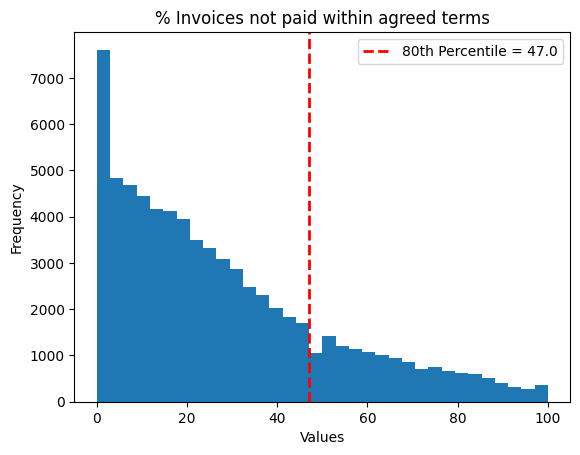

In [68]:
# Plotting the histogram with the 80th Quantile
plt.hist(data['% Invoices not paid within agreed terms'],bins=34)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

Creating Flag Variable

In [69]:
# creating target variable using '% Invoices not paid within agreed terms' feature
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

<Axes: >

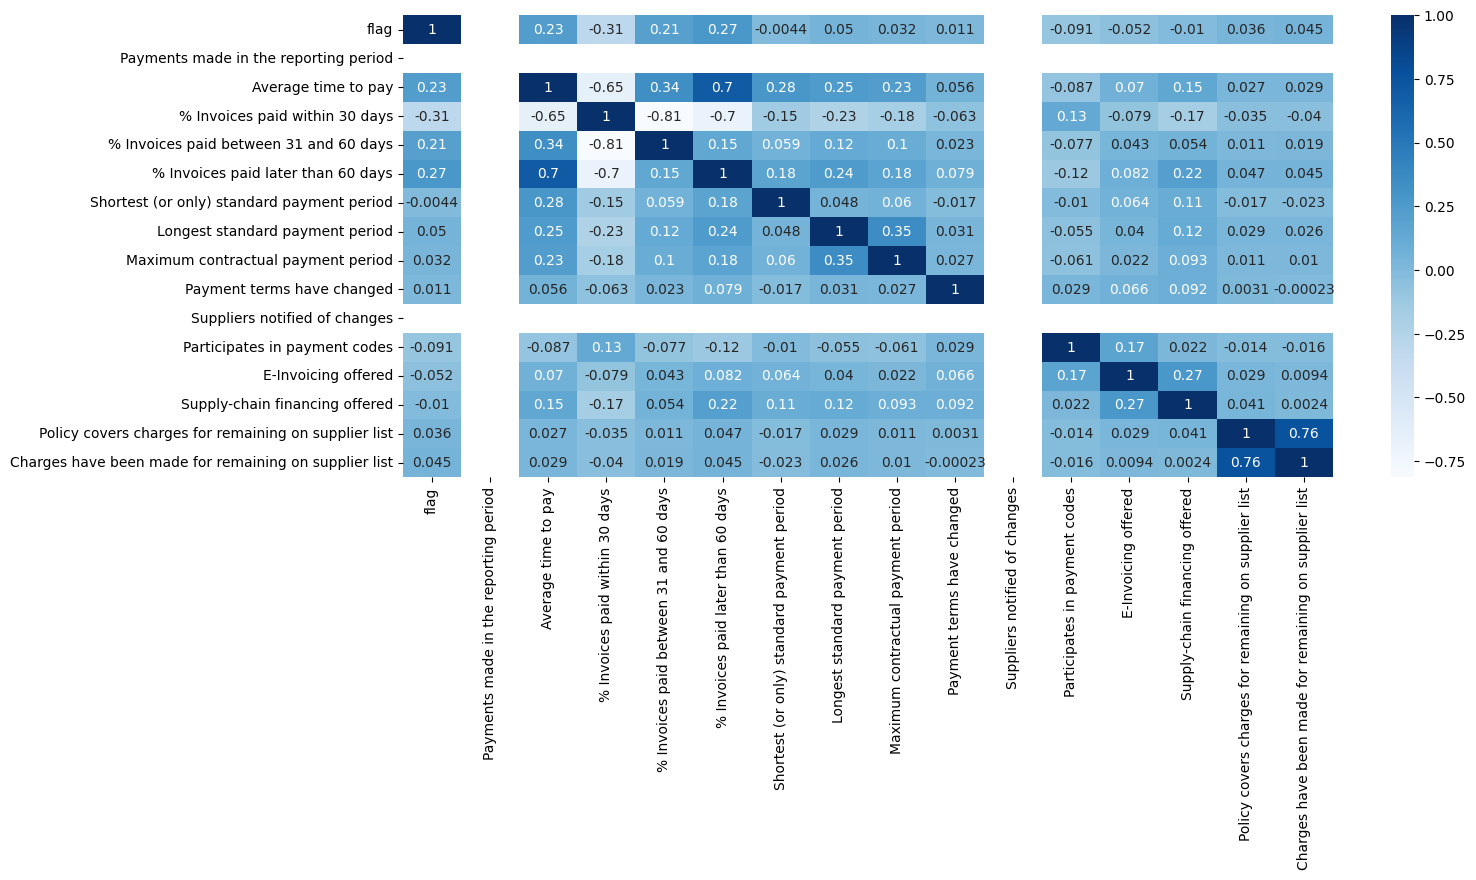

In [73]:
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Correlation Analysis
plt.figure(figsize=(15, 6))
sns.heatmap(data.reindex(columns=new_order).corr(),annot=True,cmap='Blues')

In [74]:
data.columns

Index(['Average time to pay', '% Invoices paid within 30 days',
       '% Invoices paid between 31 and 60 days',
       '% Invoices paid later than 60 days',
       'Shortest (or only) standard payment period',
       'Longest standard payment period', 'Maximum contractual payment period',
       'Payment terms have changed', 'Participates in payment codes',
       'E-Invoicing offered', 'Supply-chain financing offered',
       'Policy covers charges for remaining on supplier list',
       'Charges have been made for remaining on supplier list', 'flag'],
      dtype='object')

In [75]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=['% Invoices paid within 30 days',
                            '% Invoices paid later than 60 days',
                            'Policy covers charges for remaining on supplier list',
                            'Payments made in the reporting period'])

KeyError: "['Payments made in the reporting period'] not found in axis"

Random Oversampling

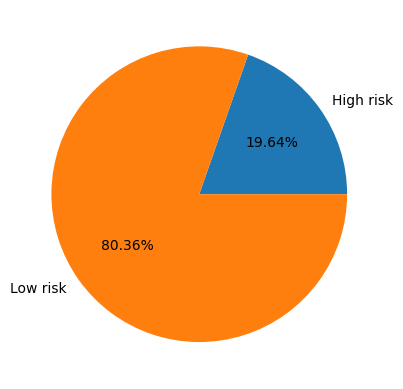

In [ ]:
# Calculate the percentage of high risk and low risk samples before Oversampling
high_risk_percentage = round((data['flag'].value_counts()[1] / data.shape[0]) * 100, 2)
low_risk_percentage = round((data['flag'].value_counts()[0] / data.shape[0]) * 100, 2)

plt.pie([high_risk_percentage,low_risk_percentage],labels=['High risk','Low risk'],autopct="%1.2f%%")
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')

# Separate the features and target
X = data1.drop('flag', axis=1)
y = data1['flag']

# Oversample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Print the new class distribution
print(f"New class distribution: {y_resampled.value_counts(normalize=True)}")

New class distribution: flag
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
data1 = pd.DataFrame(X_resampled, columns=X.columns)  # Use original feature names
data1["flag"] = y_resampled  # Add target variable
data1 = data1.sample(frac=1, random_state=42)  # Set random state for reproducibility

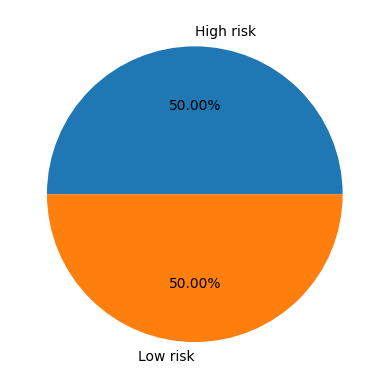

In [ ]:
# Calculate the percentage of high risk and low risk samples after Oversampling
high_risk_percentage = round((y_resampled.value_counts()[1] / data1.shape[0]) * 100, 2)
low_risk_percentage = round((y_resampled.value_counts()[0] / data1.shape[0]) * 100, 2)

plt.pie([high_risk_percentage,low_risk_percentage],labels=['High risk','Low risk'],autopct="%1.2f%%")
plt.show()

**Implementing XGBoost**

In [ ]:
categorical_features = ['Payment terms have changed',
                        'Participates in payment codes',
                        'E-Invoicing offered',
                        'Supply-chain financing offered',
                        'Charges have been made for remaining on supplier list',]

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier

params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

TypeError: Expecting a sequence of strings for feature names, got: <class 'pandas.core.indexes.base.Index'>

In [ ]:
from sklearn.metrics import classification_report,f1_score,auc
print(classification_report(y_test, xgb_pred_bin))

              precision    recall  f1-score   support

           0       0.79      0.72      0.76     17081
           1       0.75      0.81      0.78     17067

    accuracy                           0.77     34148
   macro avg       0.77      0.77      0.77     34148
weighted avg       0.77      0.77      0.77     34148



**Implementing Random Forest**

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

rf_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9044


In [ ]:
from sklearn.metrics import classification_report,f1_score,auc
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     17081
           1       0.87      0.96      0.91     17067

    accuracy                           0.90     34148
   macro avg       0.91      0.90      0.90     34148
weighted avg       0.91      0.90      0.90     34148



**Implementing XGBoost**

In [ ]:
data1['%']